In [37]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mat_utils import *
from block_matrix import *
from experiments.thermal.thm_models import make_model
import porepy as pp


model = make_model(
    {
        'physics': 1,
        "geometry": 1,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()



Sim time: 0, Dt: 0.5
350.00000222607883, 350.00034833859615
sticking: 4, sliding: 0, open: 0


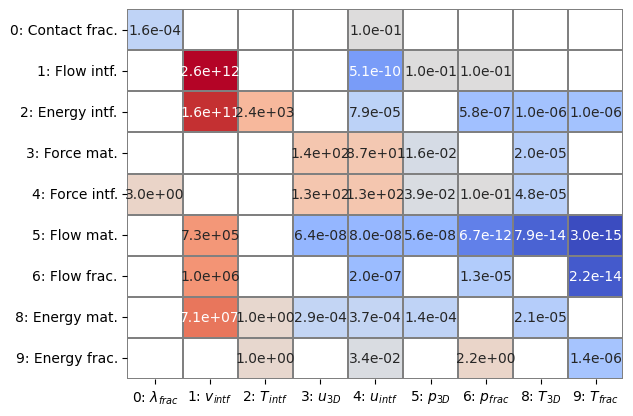

In [38]:
data = load_data(f"../../stats/{model.simulation_name()}.json")
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    data, 2, "../../matrices"
)
model.linear_system = mat, rhs
model.bmat.mat = mat
J = model.bmat[:]
J.plot_max()

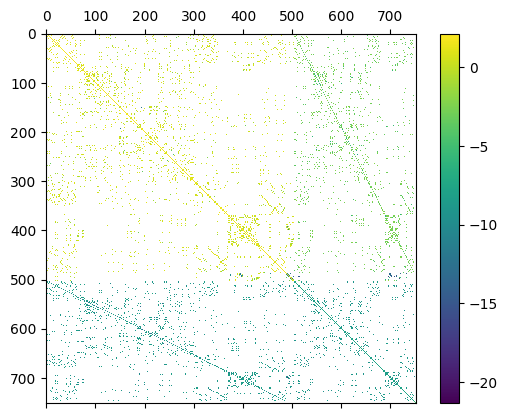

In [39]:
# Jmat = J[[2,4]]
Jmat = J[[3,4,5,6]]
Jmat.matshow()

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Solve  took: 0.0
True residual: 0.00011340764214255727
PETSc Converged Reason: 3


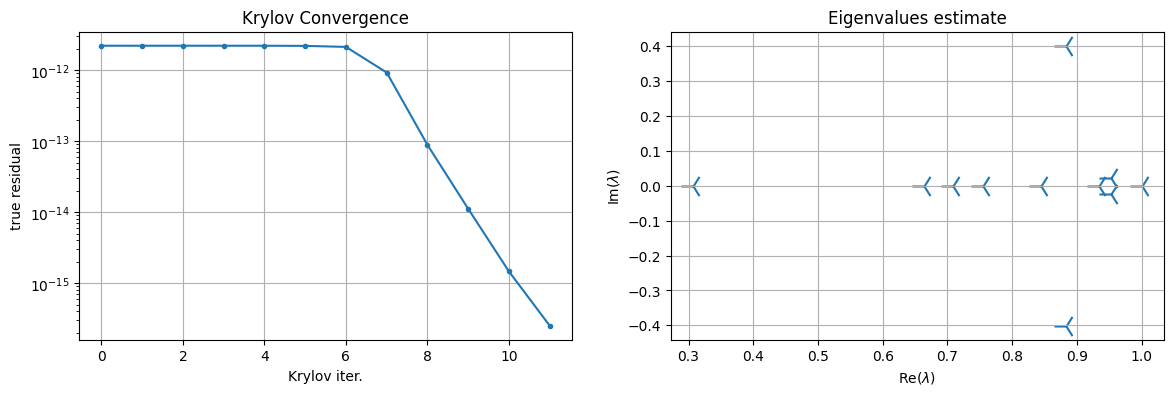

In [40]:
from fixed_stress import (
    make_fs_analytical,
    make_fs_thermal,
    block_matrix,
    get_fixed_stress_stabilization_energy,
    get_fs_fractures_analytical,
    get_fixed_stress_stabilization,
)
from hm_solver import build_mechanics_near_null_space

solve_petsc_3(
    bmat=Jmat,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        preconditioner=FieldSplitScheme(
            groups=[3,4],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[3,4]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model, include_intf=True),
            ),
            invertor_type="physical",
            invertor=lambda bmat: block_matrix(
                bmat[[5,6]],
                {
                    (5, 5): get_fixed_stress_stabilization(model, l_factor=1),
                    (6, 6): get_fs_fractures_analytical(model),
                },
            ).mat,
            complement=FieldSplitScheme(
                groups=[5,6],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            ),
        ),
    ),
)